# MP1 MountainCar Miniproject Notebook

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import secrets

## 2 Random Agent Class

This code block describes the implementation of a random agent as described in task 2 of the project handout.

In [2]:
class RandomAgent:
    def __init__(self, environment):
        self.env = environment

    def observe(self, state, action, next_state, reward):
        # This method is just a placeholder for the random agent, as it doesn't learn from observations.
        return

    def select_action(self, state):
        # Randomly select an action from the action space
        # The state therefore does not need to be taken into account
        return self.env.action_space.sample()

    def update(self):
        # No update necessary for a random agent.
        return

Run the agent on the environment until the episode is either truncated or terminated. Store the episode and render (visualize) it.

In [3]:
def run_single_episode(agent):
    """Run the RandomAgent for a single episode
    """
    done = False
    state, _ = agent.env.reset()
    episode_reward = 0
    states = [state]

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = agent.env.step(action)
        episode_reward += reward
        
        # observe and update does not do anything for the random agent
        agent.observe(state, action, next_state, reward)
        agent.update()
        
        state = next_state
        states.append(state)

        done = terminated or truncated

    return episode_reward, states

In [4]:
def plot_states_over_time(states):
    """Plot a run of a single episode for the RandomAgent.
    """
    # Extract positions and velocities from states
    positions = [s[0] for s in states]
    velocities = [s[1] for s in states]
    timesteps = list(range(len(states)))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, positions, label='Position')
    plt.title('Car Position Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, velocities, label='Velocity')
    plt.title('Car Velocity Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Episode reward after taking random actions: -200.0


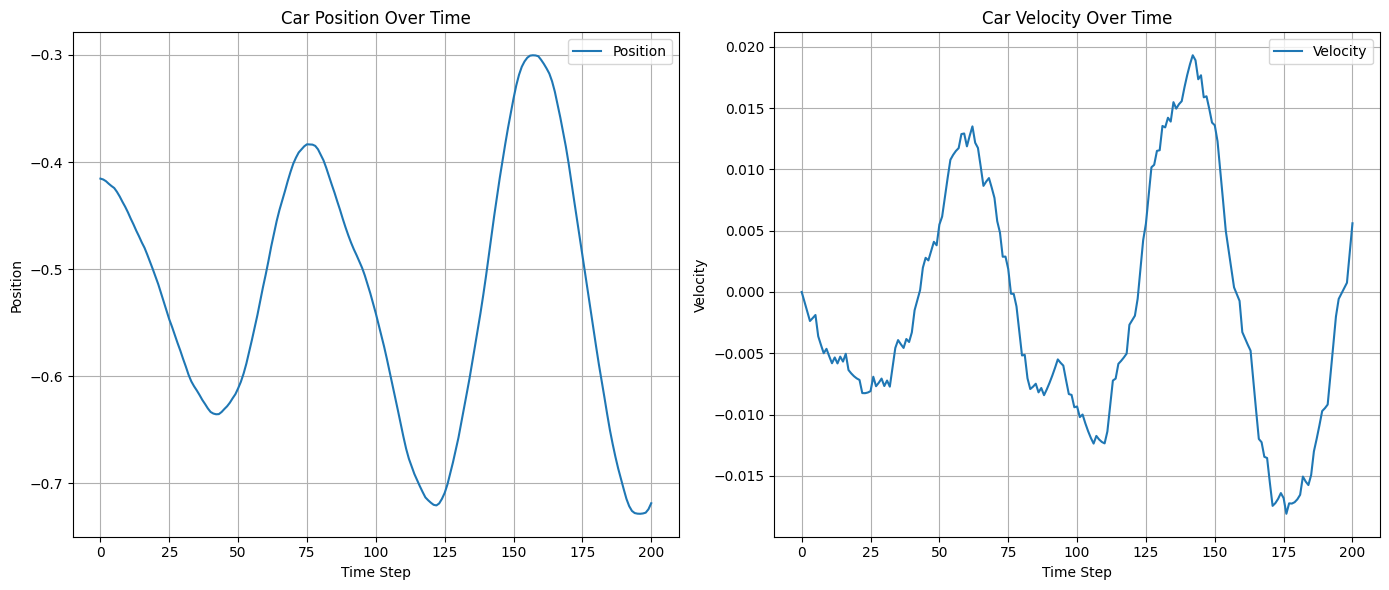

In [5]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
episode_reward, states = run_single_episode(random_agent)
print(f"Episode reward after taking random actions: {episode_reward}")
plot_states_over_time(states)

Run the agent for 100 episodes. At every episode initialize the environment with a new randomly sampled seed. Plot the duration of each episode as a scatter plot.

In [18]:
def run_multiple_episodes(agent, num_episodes=100):
    episode_durations = []

    for _ in range(num_episodes):
        done = False
        # Pass integer to forcibly reset PRNG of environment according to gymnasium docs
        # secrets.randbits() generates a random integer with 64 bits
        random_integer = secrets.randbits(64)  
        state, _ = agent.env.reset(seed=random_integer)
        episode_length = 0

        while not done:
            action = agent.select_action(state)
            state, _, terminated, truncated, _ = agent.env.step(action)
            episode_length += 1
            done = terminated or truncated
        
        episode_durations.append(episode_length)
    
    return episode_durations

In [19]:
def plot_episode_durations(episode_durations):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title("Duration of Each Episode")
    plt.xlabel("Episode Number")
    plt.ylabel("Duration (in steps)")
    plt.grid(True)
    plt.show()

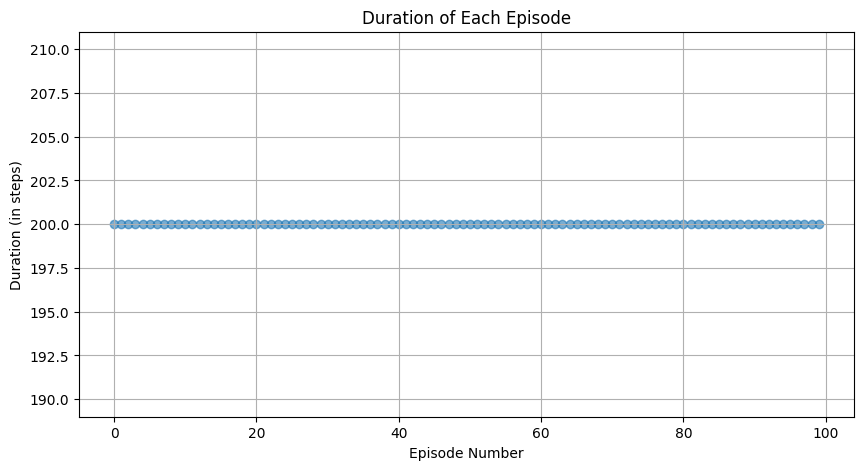

In [20]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
durations = run_multiple_episodes(random_agent, 100)
plot_episode_durations(durations)

Note from [Gymnasium Docs](https://www.gymlibrary.dev/environments/classic_control/mountain_car/#episode-end):

> The episode ends if either of the following happens:
>
> 1. **Termination:** The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
> 2. **Truncation:** The length of the episode is 200.

So it appears the episode was always truncated before the goal could be reached (i.e. random policy is bad).

## 3  DQN Agent Class

This code block describes the implementation of a DQN agent as described in task 3 of the project handout.

### 3.1 Implementation

In [21]:
# Imports for DQN agent, neural network, and replay buffer
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Define the Q-network as a MLP
class QNetwork(nn.Module):
    """
    a multi-layer perception (MLP) that takes a state s as input and outputs Q(s,a) for each
    action a

    Attributes
    ----------
    state_size:
        Number of input features, which corresponds to the dimension of the state space.
    action_size:
        Number of output features, which corresponds to the number of possible actions.
    hidden_layers:
        A list specifying the number of neurons in each hidden layer.
        Deafault is two hidden layers with 64 neurons each.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64]):
        super(QNetwork, self).__init__()
        layers = []
        input_size = state_size
        
        # Fully conected layers with ReLU activation
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, action_size))
        self.model = nn.Sequential(*layers) # Unpack list of layers into a sequential model
    
    def forward(self, x):
        return self.model(x)

In [23]:
# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, state, action, next_state, reward, done):
        self.buffer.append((state, action, next_state, reward, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [24]:
class DQNAgent:
    """
    DQN agent that uses a feed-forward network to estimate Q-values
    and an epsilon-greedy policy to take actions

    Attributes
    ----------
    Q:
        Approximates the Q-values for each state-action pair using a feed-forward neural network.
    replay_buffer:
        Stores experiences as tuples and allows for random sampling to train the Q-network.
        
    Methods
    -------
    update_target_network():
        Updates the target network to match the Q-network to stabilize training.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.current_loss = None
        
        self.Q = QNetwork(state_size, action_size, hidden_layers).to(device)
        self.target_Q = QNetwork(state_size, action_size, hidden_layers).to(device)
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.update_target_network()
        
    def update_target_network(self):
        self.target_Q.load_state_dict(self.Q.state_dict())

    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        # Debugging
        # print(f"states shape: {states.shape}")
        # print(f"next_states shape 2: {next_states.shape}")
        # print(f"actions shape: {actions.shape}")
        
        current_q_values = self.Q(states).gather(1, actions)
        next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss

In [25]:
# Test the DQN agent
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)

num_episodes = 10
for episode in range(num_episodes):
    # Pass integer to forcibly reset PRNG of environment according to gymnasium docs
    # secrets.randbits() generates a random integer with 64 bits
    random_integer = secrets.randbits(64)  
    state, _ = env.reset(seed=random_integer)
    done = False
    
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        dqn_agent.observe(state, action, next_state, reward, done)
        dqn_agent.update()
        
        state = next_state
        
    dqn_agent.update_target_network()
    print(f"Episode {episode + 1}/{num_episodes} finished")

Episode 1/10 finished
Episode 2/10 finished
Episode 3/10 finished
Episode 4/10 finished
Episode 5/10 finished
Episode 6/10 finished
Episode 7/10 finished
Episode 8/10 finished
Episode 9/10 finished
Episode 10/10 finished


### 3.2 No auxiliary reward

Train the DQNAgent for 1000 episodes and report its loss and average cumulative reward per episode.

In [26]:
def train_dqn(agent, env, num_episodes=1000):
    episode_rewards = []
    losses = []

    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        episode_loss = []

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.observe(state, action, next_state, reward, done)
            agent.update()

            cumulative_reward += reward
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)

        agent.update_target_network()
        episode_rewards.append(episode_reward)
        
        # Append average loss for this episode
        if episode_loss:
            losses.append(torch.mean(torch.stack(episode_loss)).item())
        else:
            losses.append(0)
            
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_rewards, losses

In [27]:
# Plotter functions for the results of training DQN for 1000 episodes
def plot_cumulative_rewards_loss(episode_rewards, losses):

    # Plotting results for cumulative reward
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.grid()

    # Plotting results for training loss over time
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid()

    plt.tight_layout()
    plt.show()

Episode 100/1000. Average reward: -200.00
Episode 200/1000. Average reward: -200.00
Episode 300/1000. Average reward: -200.00
Episode 400/1000. Average reward: -200.00
Episode 500/1000. Average reward: -200.00
Episode 600/1000. Average reward: -200.00
Episode 700/1000. Average reward: -200.00
Episode 800/1000. Average reward: -200.00
Episode 900/1000. Average reward: -200.00
Episode 1000/1000. Average reward: -200.00


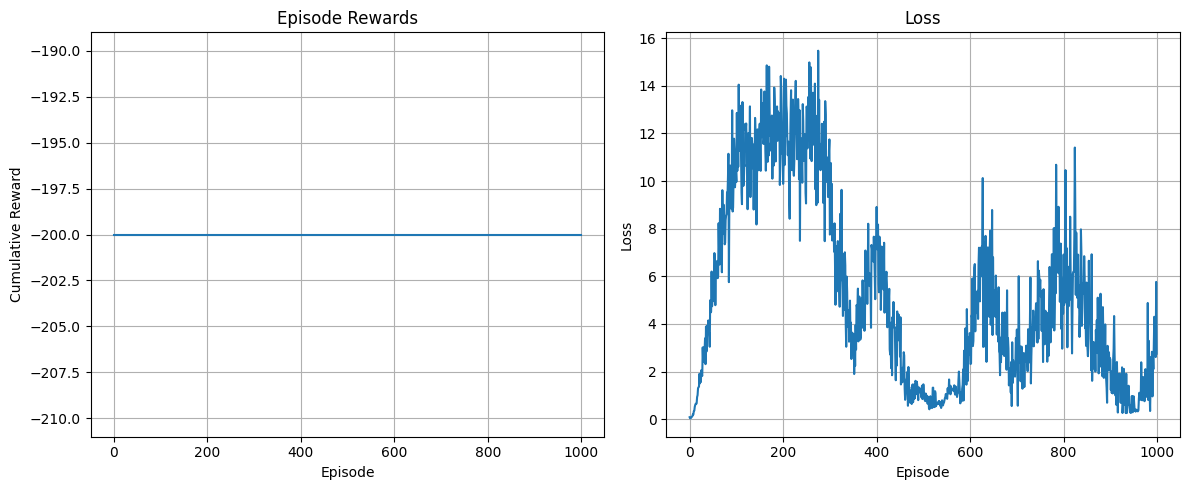

Average cumulative reward over the last 100 episodes: -200.00


In [28]:
# Train the agent
# Takes roughly 6 minutes to run
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
episode_rewards, losses = train_dqn(dqn_agent, env, num_episodes=1000)

# Plot results of training
plot_cumulative_rewards_loss(episode_rewards, losses)

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")



Does your agent solve the task?

**No, it does not.**

The main challenge of this task is the sparse reward problem discussed in the introduction. Let’s
explore ways to address this issue and help our agent to learn faster.

### 3.3 Heuristic reward function

We will now create an auxiliary reward function to assist the agent in learning better behavior. Try
to think of a reward that would help the agent solve the task. Which states location-wise should the
agent strive for?

**A possible heuristic reward is to provide positive feedback based on the agent's progress towards the goal. For example, a reward proportional to the car's position (the further right, the higher the reward).**

Note: Keep in mind that the car needs to move backwards and forwards to gain momentum.

In [29]:
def calculate_auxiliary_reward(state):
    """
    Simple auxiliary reward proportional to the car's position.
    
    Note that the position takes values between -1.2 and +0.6 in the MountainCar environment.
    Thus, it is highest when the car is closest to the flag.
    """
    position = state[0]
    return position

In [34]:
def train_dqn_with_auxiliary_reward(agent, env, num_episodes=3000):
    episode_durations = []
    episode_rewards = []
    episode_auxiliary_rewards = []
    episode_total_rewards = []
    successes = 0
    cumulative_successes = []
    losses = []
    
    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        cumulative_auxiliary_reward = 0
        episode_loss = []
        steps = 0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Calculate auxiliary reward
            auxiliary_reward = calculate_auxiliary_reward(next_state)
            total_reward = reward + auxiliary_reward
            
            agent.observe(state, action, next_state, total_reward, done)
            agent.update()
            
            cumulative_reward += reward
            cumulative_auxiliary_reward += auxiliary_reward
            steps += 1
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_auxiliary_rewards.append(cumulative_auxiliary_reward)
        episode_total_rewards.append(cumulative_reward + cumulative_auxiliary_reward)
        
        if terminated and not truncated:
            successes += 1
        
        cumulative_successes.append(successes)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_total_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
        # Append average loss for this episode
        if episode_loss:
            losses.append(torch.mean(torch.stack(episode_loss)).item())
        else:
            losses.append(0)
            
    return episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes, losses

In [35]:
def plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes):
    # Plotting results
    plt.figure(figsize=(18, 12))

    # Episode durations
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration (steps)')
    plt.grid()

    # Rewards
    plt.subplot(2, 2, 2)
    plt.plot(episode_rewards, label='Environment Reward')
    plt.plot(episode_auxiliary_rewards, label='Auxiliary Reward')
    plt.plot(episode_total_rewards, label='Total Reward')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()

    # Cumulative rewards
    plt.subplot(2, 2, 3)
    cumulative_env_rewards = np.cumsum(episode_rewards)
    cumulative_aux_rewards = np.cumsum(episode_auxiliary_rewards)
    cumulative_total_rewards = np.cumsum(episode_total_rewards)
    plt.plot(cumulative_env_rewards, label='Cumulative Environment Reward')
    plt.plot(cumulative_aux_rewards, label='Cumulative Auxiliary Reward')
    plt.plot(cumulative_total_rewards, label='Cumulative Total Reward')
    plt.title('Cumulative Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid()

    # Cumulative number of successes
    plt.subplot(2, 2, 4)
    plt.plot(cumulative_successes)
    plt.title('Cumulative Number of Successes')
    plt.xlabel('Episode')
    plt.ylabel('Number of Successes')
    plt.grid()

    plt.tight_layout()
    plt.show()

In [36]:
def plot_loss_only(losses):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

Episode 100/3000. Average reward: -292.32
Episode 200/3000. Average reward: -291.09
Episode 300/3000. Average reward: -268.54
Episode 400/3000. Average reward: -258.20
Episode 500/3000. Average reward: -230.79
Episode 600/3000. Average reward: -221.23
Episode 700/3000. Average reward: -203.84
Episode 800/3000. Average reward: -221.53
Episode 900/3000. Average reward: -205.23
Episode 1000/3000. Average reward: -198.83
Episode 1100/3000. Average reward: -207.82
Episode 1200/3000. Average reward: -208.85
Episode 1300/3000. Average reward: -206.88
Episode 1400/3000. Average reward: -216.82
Episode 1500/3000. Average reward: -180.41
Episode 1600/3000. Average reward: -193.08
Episode 1700/3000. Average reward: -202.25
Episode 1800/3000. Average reward: -183.80
Episode 1900/3000. Average reward: -170.98
Episode 2000/3000. Average reward: -179.95
Episode 2100/3000. Average reward: -180.82
Episode 2200/3000. Average reward: -201.91
Episode 2300/3000. Average reward: -181.81
Episode 2400/3000. A

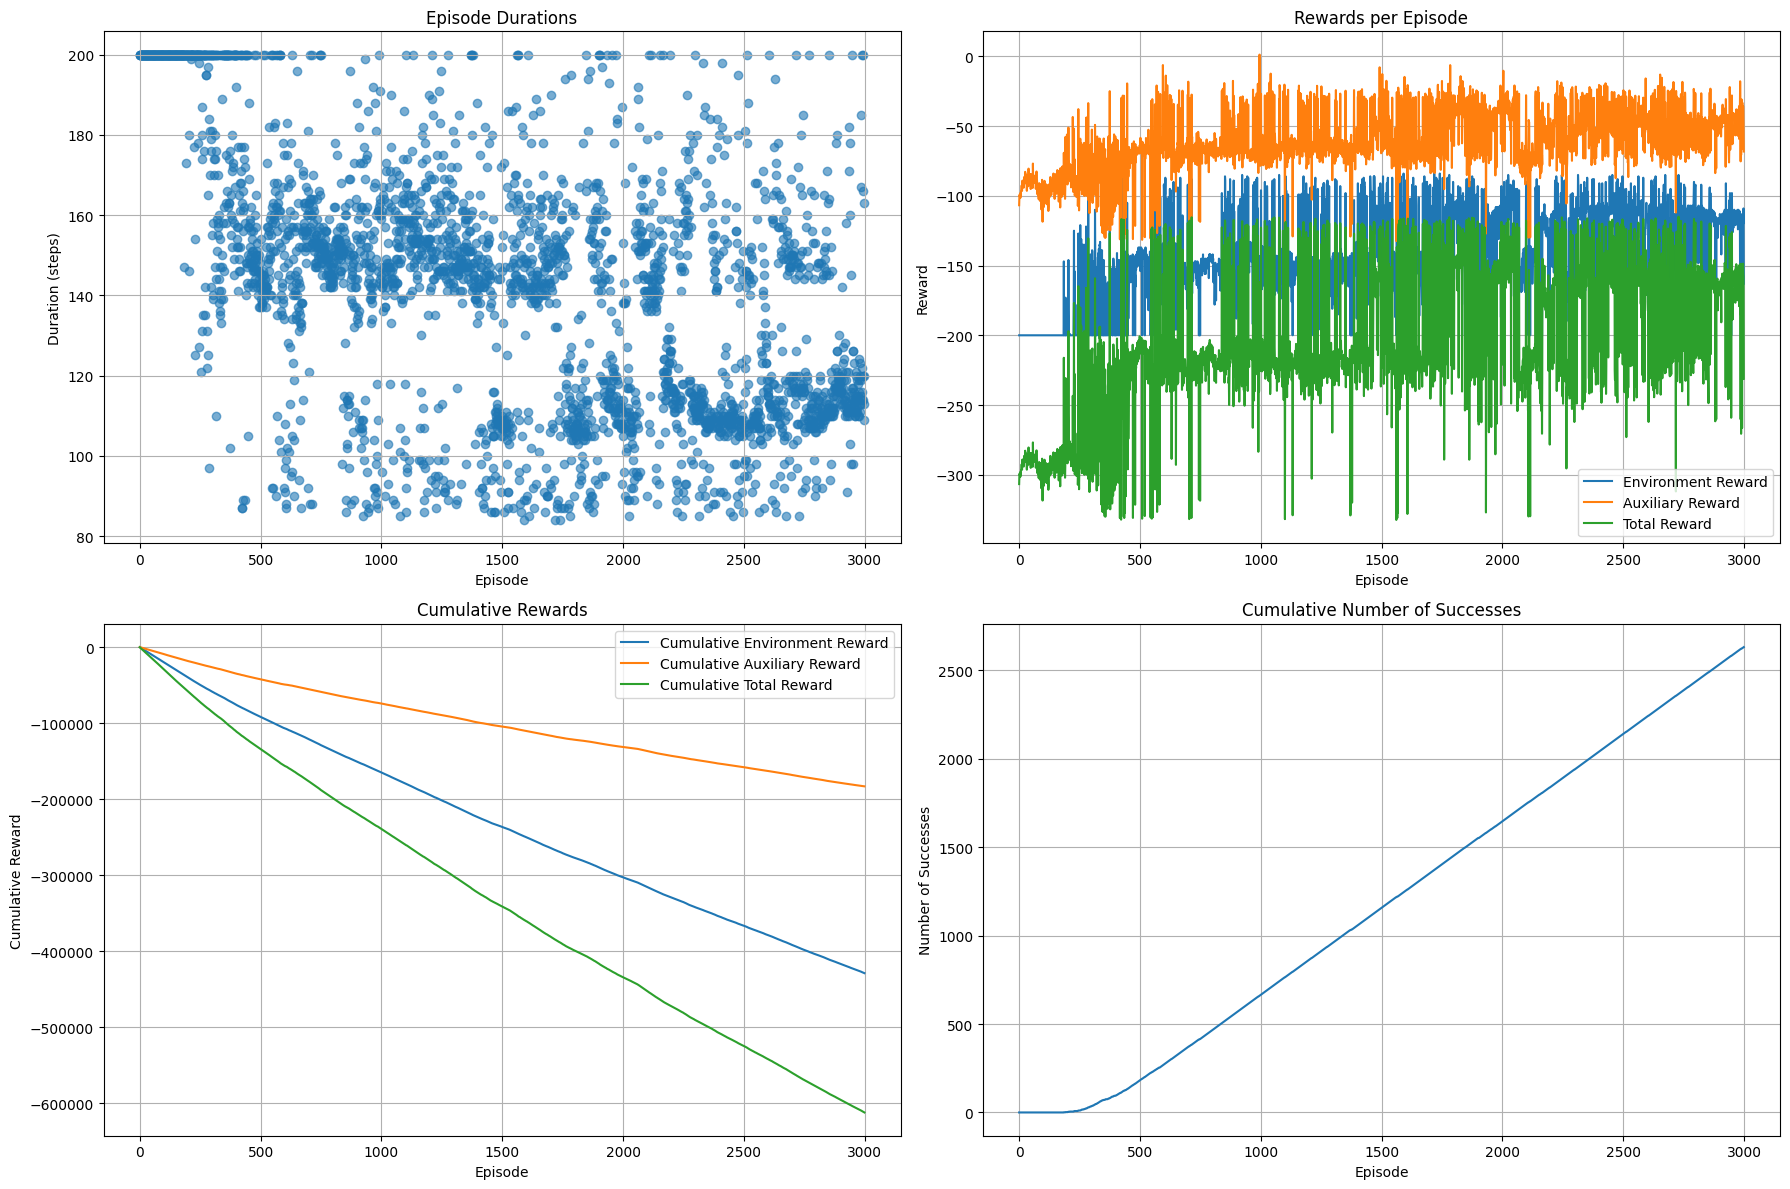

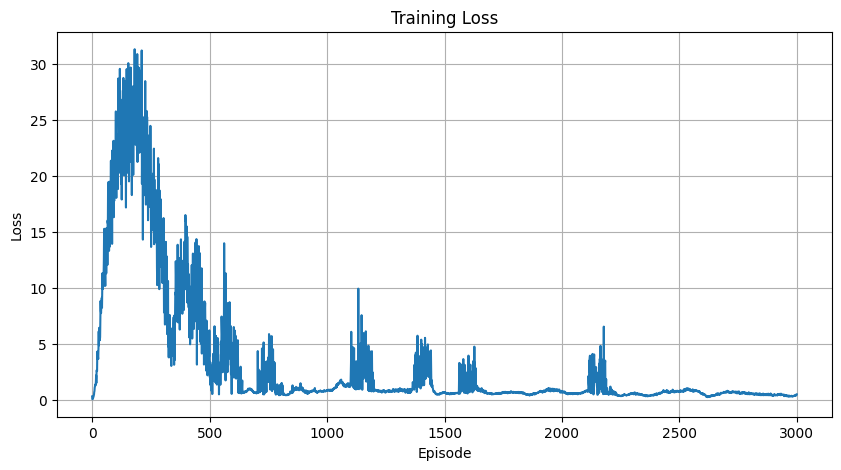

Average cumulative reward over the last 100 episodes: -168.42


In [37]:
# Train the agent with auxiliary reward
# Takes 15-20 minutes to run
dqn_agent = DQNAgent(state_size, action_size)
episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, \
    cumulative_successes, losses = train_dqn_with_auxiliary_reward(dqn_agent, env, num_episodes=3000)

# Plot results of training
plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes)
plot_loss_only(losses)

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")

Does it successfully solve the task?
What happens if you choose very small/very large auxiliary rewards?

Experiment with the parameters of your auxiliary reward to improve the performance. With a good set of parameters, it should solve the task in less than a thousand episodes.

### 3.4 Non domain-specific reward

Implementation of Random Network Distillation (RND) [Burda et al.](https://arxiv.org/pdf/1810.12894).

Consisting of:
- **Target Network** with fixed ranodom weights. Input: State, Output: Single Number.
- **Predictor Network** with adaptable weights. Input: State, Output: Single Number.

In [38]:
class RNDNetwork(nn.Module):
    def __init__(self, input_dim):
        super(RNDNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [39]:
class DQNAgent_RND(DQNAgent):
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001, reward_factor=0.1):
        super().__init__(state_size, action_size, hidden_layers, gamma, epsilon,
                         epsilon_min, epsilon_decay, replay_buffer_size, batch_size, lr)
        self.reward_factor = reward_factor
        self.predictor = RNDNetwork(state_size).to(device)
        self.target = RNDNetwork(state_size).to(device)
        self.rnd_optimizer = torch.optim.Adam(self.predictor.parameters(), lr=lr)
        
        self.state_mean = np.zeros(state_size)
        self.state_var = np.ones(state_size)
        self.rnd_mean = 0
        self.rnd_var = 1
        self.steps = 0
    
    def update_normalization_stats(self, state):
        self.steps += 1
        alpha = 1.0 / self.steps
        self.state_mean = (1 - alpha) * self.state_mean + alpha * state
        self.state_var = (1 - alpha) * self.state_var + alpha * (state - self.state_mean) ** 2
        
    def normalize_state(self, state):
        return (state - self.state_mean) / (np.sqrt(self.state_var) + 1e-8)
    
    def compute_rnd_reward(self, next_state):
        normalized_state = self.normalize_state(next_state)
        normalized_state = torch.FloatTensor(normalized_state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            target_output = self.target(normalized_state)
        predictor_output = self.predictor(normalized_state)
        
        rnd_error = (predictor_output - target_output).pow(2).mean().item()
        alpha = 1.0 / max(1, self.steps - 100) # Start normalizing after 100 steps
        self.rnd_mean = (1 - alpha) * self.rnd_mean + alpha * rnd_error
        self.rnd_var = (1 - alpha) * self.rnd_var + alpha * (rnd_error - self.rnd_mean) ** 2
        
        normalized_rnd_error = (rnd_error - self.rnd_mean) / (np.sqrt(self.rnd_var) + 1e-8)
        rnd_reward = np.clip(normalized_rnd_error, -5, 5)
        
        return rnd_reward
    
    def update_predictor(self, state):
        self.rnd_optimizer.zero_grad()
        normalized_state = self.normalize_state(state)
        normalized_state = torch.FloatTensor(normalized_state).unsqueeze(0).to(device)
        
        target_output = self.target(normalized_state)
        predictor_output = self.predictor(normalized_state)
        
        loss = nn.MSELoss()(predictor_output, target_output) # TODO: need detach()?
        loss.backward()
        self.rnd_optimizer.step()
        
        return loss.item()
    
    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)
        self.update_normalization_stats(next_state)
        
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        # Compute Q-Values
        current_q_values = self.Q(states).gather(1, actions)
        next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss.item()
        
        # Update predictor network
        for next_state in next_states:
            self.update_predictor(next_state.numpy())
            
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()
                

In [46]:
def train_dqn_rnd(agent, env, num_episodes=100):
    episode_durations = []
    episode_rewards = []
    episode_rnd_rewards = []
    episode_total_rewards = []
    cumulative_successes = []
    successes = 0
    losses = []
    
    for episode in range(num_episodes):
        random_integer = secrets.randbits(64)  
        state, _ = env.reset(seed=random_integer)
        done = False
        cumulative_reward = 0
        cumulative_rnd_reward = 0
        steps = 0
        episode_loss = []
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            rnd_reward = agent.compute_rnd_reward(next_state)
            total_reward = reward + agent.reward_factor * rnd_reward
            
            agent.observe(state, action, next_state, total_reward, done)
            agent.update()
            
            cumulative_reward += reward
            cumulative_rnd_reward += rnd_reward
            state = next_state
            steps += 1
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_rnd_rewards.append(cumulative_rnd_reward)
        episode_total_rewards.append(cumulative_reward + agent.reward_factor * cumulative_rnd_reward)
        
        if terminated and not truncated:
            successes += 1
            
        cumulative_successes.append(successes)
        
        # Append average loss for this episode
        if episode_loss:
            episode_loss_tensors = [torch.tensor(loss) if not isinstance(loss, torch.Tensor) else loss for loss in episode_loss]
            losses.append(torch.mean(torch.stack(episode_loss_tensors)).item()) # TODO: need loss.detach().numpy() for loss in?
        else:
            losses.append(0)
            
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_total_rewards[-10:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses

Train the agent with RND reward and plot results.

Episode 10/100. Average reward: -202.46
Episode 20/100. Average reward: -203.19
Episode 30/100. Average reward: -202.24
Episode 40/100. Average reward: -201.36
Episode 50/100. Average reward: -201.33
Episode 60/100. Average reward: -201.53
Episode 70/100. Average reward: -201.19
Episode 80/100. Average reward: -201.39
Episode 90/100. Average reward: -200.95
Episode 100/100. Average reward: -201.73


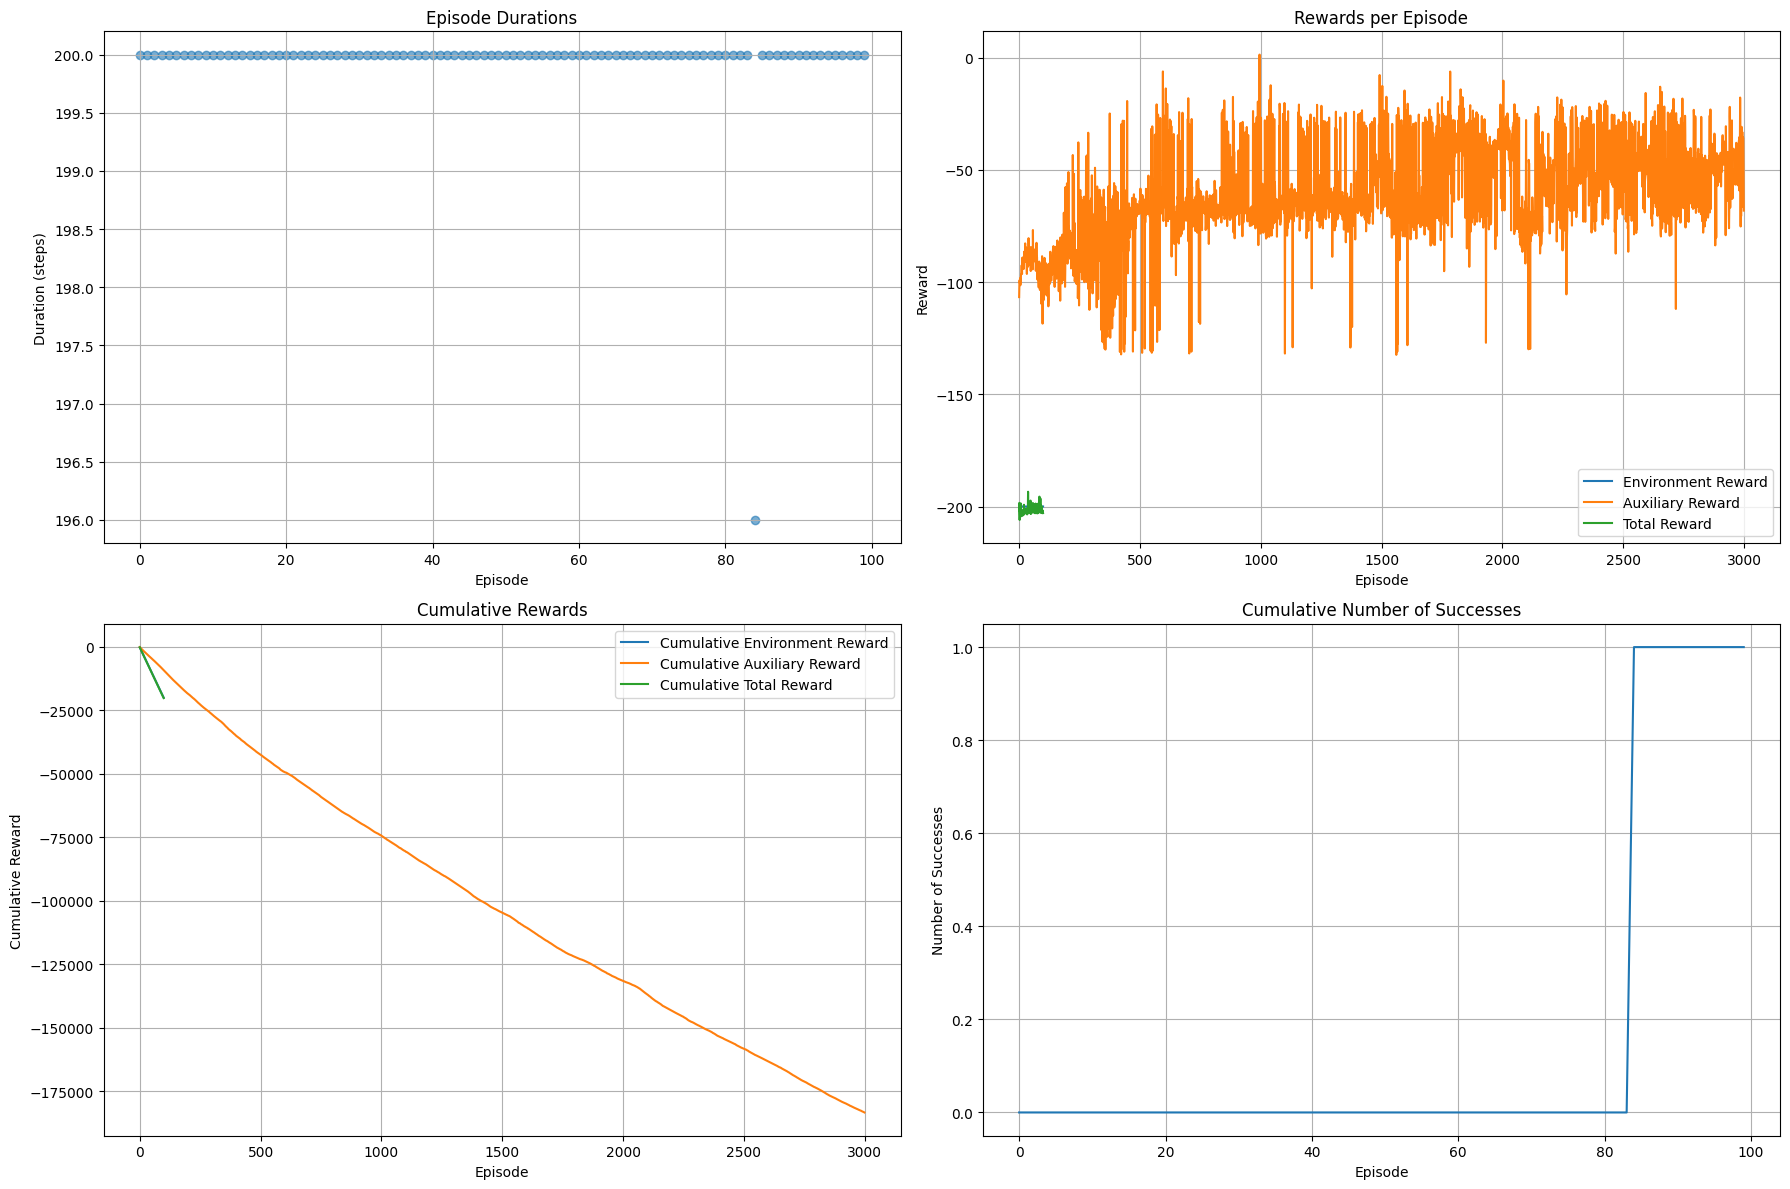

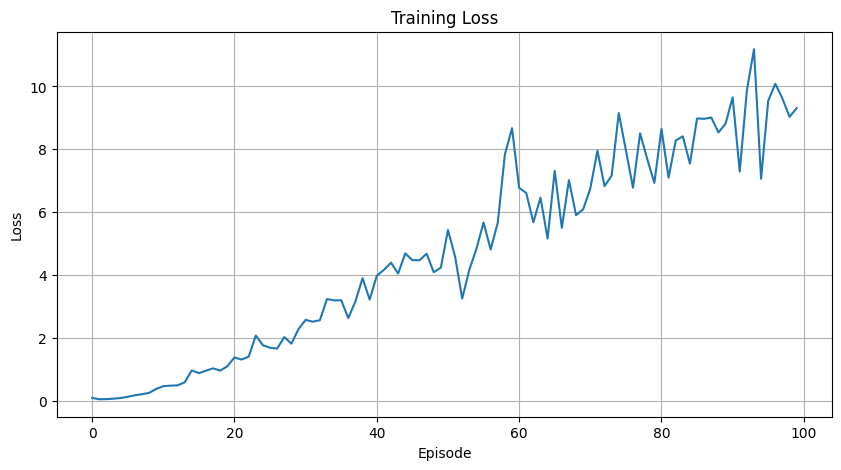

Average cumulative reward over the last 10 episodes: -201.73


In [47]:
# Takes 65-70 minutes to run
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_rnd_agent = DQNAgent_RND(state_size, action_size)
episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses = \
    train_dqn_rnd(dqn_rnd_agent, env, num_episodes=100)

# Plot results of training
plot_durations_rewards_cumulative_rewards_successes(episode_durations, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes)
plot_loss_only(losses)

# Calculate and print average cumulative reward over the last 10 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-10:])
print(f"Average cumulative reward over the last 10 episodes: {average_cumulative_reward:.2f}")

## Dyna Agent Class

#### This code block describes the implementation of a Dyna agent as described in task 4 of the project handout.

### 4.1 State Discretization, 4.2 Model Building & 4.3 Implementation

In [49]:
class DynaAgent:
    def __init__(self,  environment, discr_step=np.array([0.025, 0.005]), gamma=0.99, epsilon=0.9, epsilon_min=0.05, 
                 epsilon_decay=0.995, k=10, number_of_episodes=10):
        
        # Initialize attributes that can be passed as simple parameters
        self.discr_step = discr_step
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.k = k
        self.number_of_episodes = number_of_episodes
        self.environment = environment

        # Perform discretization of the state space and store it with the agent object using simple numpy functions
        self.discrete_positions = np.arange(start=environment.observation_space.low[0], stop=environment.observation_space.high[0], step=discr_step[0])
        self.discrete_velocities = np.arange(start=environment.observation_space.low[1], stop=environment.observation_space.high[1], step=discr_step[1])

        # Store the number of discrete states as well as the number of actions in separate attributes
        self.n_states = self.discrete_positions.size * self.discrete_velocities.size
        self.n_actions = environment.action_space.n

        # Initialize complex attributes and adjust dependent attributes based on passed parameters
        self.P_hat = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        self.P_hat[:, :, :] = np.full(shape=self.n_states, fill_value=(1/self.n_states))
        self.R_hat = np.zeros(shape=(self.n_states, self.n_actions))
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))

        # Initialize helper attributes for updating the model view of the agent
        self.visit_counts = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        self.cumulative_returns = np.zeros(shape=(self.n_states, self.n_actions))

        # Store a list keeping track of previously encountered state-action pairs
        self.state_action_buffer = []
    
    def discretize_state(self, state):

        posi, velo = state

        # Performs discretization by rounding down the continuous state value to the adjacent lower discrete state value
        posiIndex = np.digitize(posi, self.discrete_positions) - 1
        veloIndex = np.digitize(velo, self.discrete_velocities) - 1

        # Returns the logical index of the discretized state in our data structures of size n_states
        return posiIndex * self.discrete_velocities.size + veloIndex

        
    def observe(self, state, action, next_state, reward):

        # Perform the 4 states outlined in the handout

        # Step 1: Discretize the obtained states s and s'

        # Note that the state indices are returned by the function
        state_s_index = self.discretize_state(state)
        state_sPrime_index = self.discretize_state(next_state)

        # Record visited state-action pairs in our buffer structure
        # Note that we store the index of the visited state as it enables more lightweight coding
        self.state_action_buffer.append((state_s_index, action))

        # Step 2: Update the model of the transition probabilities and the expected reward

        self.visit_counts[state_s_index][action][state_sPrime_index] += 1
        self.cumulative_returns[state_s_index][action] += reward

        self.P_hat[state_s_index][action] = self.visit_counts[state_s_index][action] / np.sum(self.visit_counts[state_s_index][action])
        self.R_hat[state_s_index][action] = self.cumulative_returns[state_s_index][action] / np.sum(self.visit_counts[state_s_index][action])

        # Step 3: Update the Q-value at state s according to the formula on the handout

        # Perform the actual Q-value update
        term = np.dot(self.P_hat[state_s_index][action], np.max(self.Q, axis=1))
        self.Q[state_s_index][action] = self.R_hat[state_s_index][action] + (self.gamma * term)

        # Step 4: Perform k further Q-value updates for randomly chosen state-action pairs that were already encountered

        for _ in range(self.k):

            # Randomly choose an already encountered state-action pair
            idx, act = random.choice(self.state_action_buffer)

            # Now perform the actual update of the Q-value as in Step 3
            term = np.dot(self.P_hat[idx][act], np.max(self.Q, axis=1))
            self.Q[idx][act] = self.R_hat[idx][act] + (self.gamma * term)

        return

    def select_action(self, state):

        # Pick an action from the given state according to epsilon greedy policy on the Q-values

        if np.random.rand() <= self.epsilon:
            return self.environment.action_space.sample()
        else:
            discreteState = self.discretize_state(state)
            valsQ = self.Q[discreteState]
            return np.argmax(valsQ)

    def update(self):

        episode_durations = []

        # Runs the training procedure

        for episode in range(self.number_of_episodes):
            random_integer = secrets.randbits(64)  
            state, _ = self.environment.reset(seed=random_integer)
            done = False
            episode_length = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.environment.step(action)
                done = terminated or truncated

                self.observe(state, action, next_state, reward)

                # Remember to adjust the epsilon value to decay in training
                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

                state = next_state

                episode_length += 1

            episode_durations.append(episode_length)
            
            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{self.number_of_episodes} finished with length {episode_length}")
        
        return episode_durations

### 4.4 Results

#### We first run the DynaAgent with no auxiliary reward for 3000 episodes.

In [50]:
# We try to train Dyna with no auxiliary reward for 1000 episodes to see what happens.
# Takes 1-2 minutes to run
env = gym.make("MountainCar-v0")
agent = DynaAgent(env, number_of_episodes=1000)
agent.update()
print("Done")
# Running 3000 episodes should take roughly 6 minutes

Episode 100/1000 finished with length 200
Episode 200/1000 finished with length 159
Episode 300/1000 finished with length 158
Episode 400/1000 finished with length 117
Episode 500/1000 finished with length 155
Episode 600/1000 finished with length 151
Episode 700/1000 finished with length 149
Episode 800/1000 finished with length 108
Episode 900/1000 finished with length 136
Episode 1000/1000 finished with length 152
Done


##### Question: Does it solve the task?
Yes it does, as one can infer from the length of the episodes going down indicating success.